In [45]:
import pandas as pd
from matplotlib import pyplot as plt
from math import log2, log10
import pickle
import cobra
from glob import glob
%matplotlib inline

In [46]:
plt.rcParams['figure.figsize'] = [12.0, 4.0]

In [48]:
for kind in ['fluxes']:
    joined = pd.DataFrame()
    for file in glob('./supplemented_first_good/%s.csv' % kind):
        df = pd.read_csv(file, index_col=0)
        joined = joined.join(df, how='outer')
df = joined.T[~ joined.columns.isin(['default'])].T
default_series = joined['default']

KeyError: 'default'

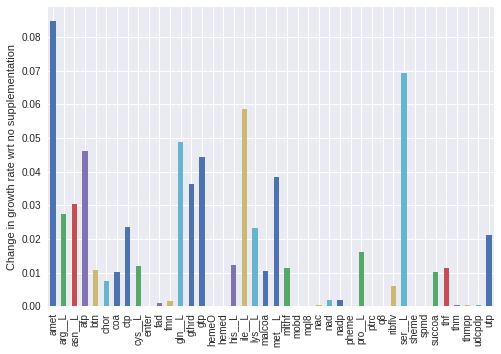

In [39]:
ax = (df.loc['biomass_dilution'] - default_series['biomass_dilution']).plot(kind='bar')
ax.set_ylabel('Change in growth rate wrt no supplementation')

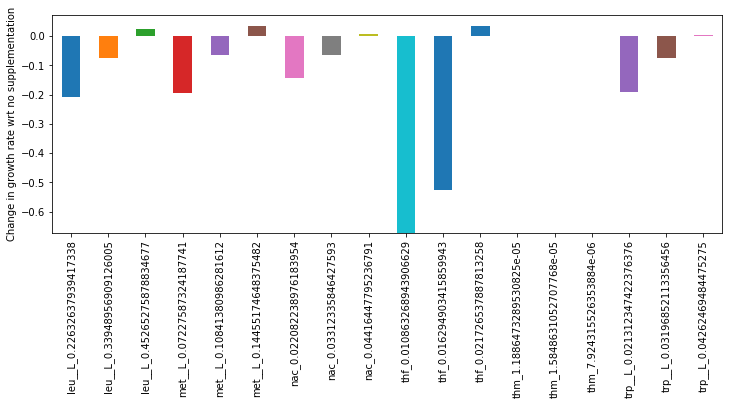

In [63]:
ax = (df.loc['biomass_dilution'] - default_series['biomass_dilution']).plot(kind='bar')
ax.set_ylabel('Change in growth rate wrt no supplementation')

In [40]:
# Get list of reactions forming complexes w/ iron cofactors
iron_cofactors = ['mod_fe2', 'mod_pheme', 'mod_hemed', 'mod_4fe4s', 'mod_sheme', 'mod_3fe4s', 'mod_3fe4s', 'mod_2fe2s', 'mod_fe3', 'mod_NiFeCoCN2', 'mod_hemeO']
iron_enzymes = []
for i in df.index:
    if 'formation_' not in i:
        continue
    for cofactor in iron_cofactors:
        if cofactor in i:
            iron_enzymes.append(i)

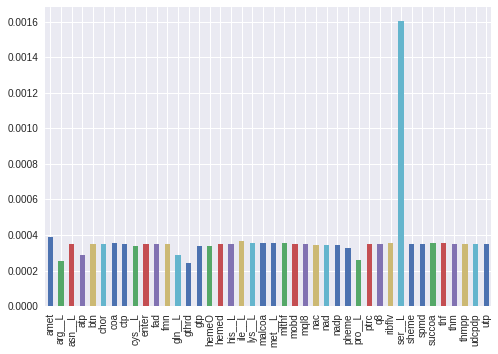

In [41]:
uptake_activity = df.loc['EX_fe3_e'] / df.T['biomass_dilution']
default_uptake = default_series['EX_fe3_e'] / default_series['biomass_dilution']
abs(uptake_activity).plot(kind='bar')

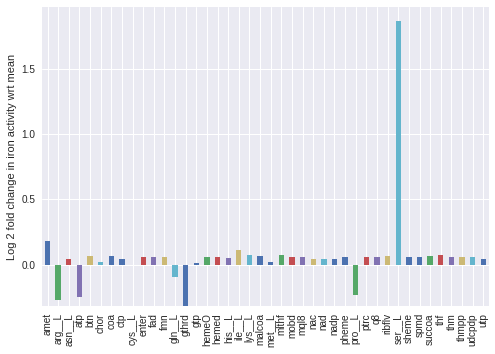

In [44]:
# Sum fluxes through iron containing enzymes
iron_activity = df.loc[iron_enzymes] / df.T['biomass_dilution']
iron_activity[iron_activity < 1e-20] = 0
default_iron_activity = default_series[iron_enzymes]
log2_iron = (iron_activity.sum().map(log2) - log2(default_iron_activity.sum()))
ax = log2_iron.plot(kind='bar')
ax.set_ylabel('Log 2 fold change in iron activity wrt mean')

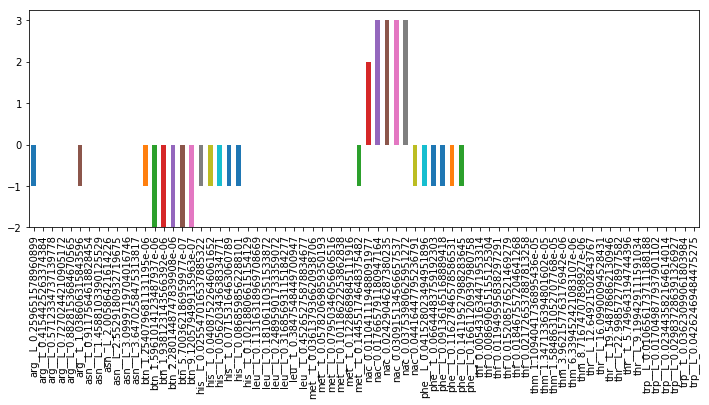

In [8]:
# Number of iron reactions active
iron_activity[iron_activity > 1e-20] = 1
default_iron_activity[default_iron_activity>0] = 1
(iron_activity.sum() - default_iron_activity.sum()).plot(kind='bar')

In [9]:
# Get list of enzymes active
enzymes = []
for i in df.index:
    if 'formation_' not in i:
        continue
    enzymes.append(i)

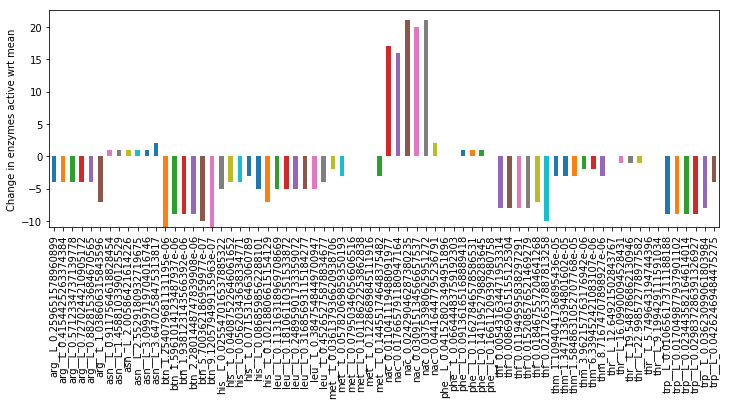

In [10]:
enzyme_activity = df.loc[enzymes]
default_enzyme_activity = default_series[enzymes]

enzyme_activity[enzyme_activity > 1e-20] = 1
default_enzyme_activity[default_enzyme_activity > 1e-20] = 1

ax = (enzyme_activity.sum() - default_enzyme_activity.sum()).plot(kind='bar')
ax.set_ylabel('Change in enzymes active wrt mean')

In [11]:
# Get list of enzymes active
enzymes = []
for i in df.index:
    if 'formation_' not in i:
        continue
    enzymes.append(i)

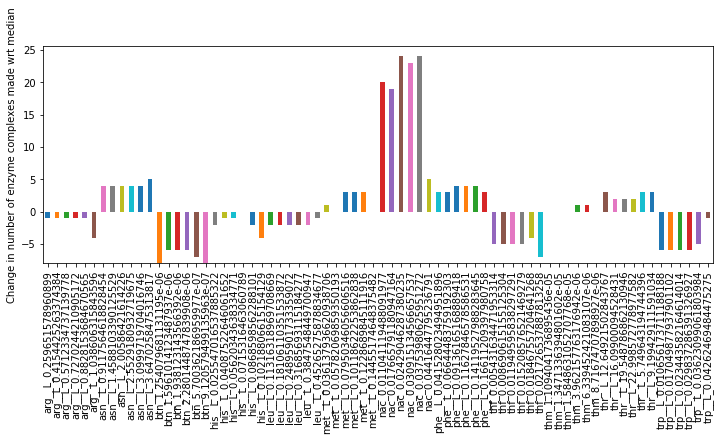

In [12]:
enzyme_activity = df.loc[enzymes]
default_enzyme_activity = default_series[enzymes]

enzyme_activity[enzyme_activity > 1e-20] = 1
default_enzyme_activity[default_enzyme_activity > 1e-20] = 1
ax = (enzyme_activity.sum() - enzyme_activity.sum().median()).plot(kind='bar')
ax.set_ylabel('Change in number of enzyme complexes made wrt median')

## How additions change metabolic state

In [24]:
norm_df = df / df.loc['biomass_dilution']
norm_df[abs(norm_df) < 1e-20] = 0

In [25]:
filter_df = norm_df.copy()
filter_df[filter_df>0] =1
rxns_to_make_zero = filter_df[filter_df.T.sum()  <= 1].index

In [26]:
with open('/home/sbrg-cjlloyd/multime/multime/iJL1678b_ML_keffs.pickle', 'rb') as f:
    me = pickle.load(f)

In [27]:
pca_dict = {}
for met in norm_df.dropna(how='any').columns:
    norm_df.loc[rxns_to_make_zero, met] = 0
    sol = cobra.core.Solution(.1, x_dict=norm_df[met].to_dict(), status='optimal')
    pca_dict[met] = me.get_metabolic_flux(solution=sol)

In [28]:
pca_df = pd.DataFrame(pca_dict)

In [29]:
pca_df = pca_df.T[[i for i in pca_df.index if 'DM_RNA' not in i]].T

In [30]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
expression_values = preprocessing.StandardScaler().fit_transform(pca_df.T)
#expression_values = pca_df
#expression_values = zscore(filtered_df.T, axis=1)
pca = PCA(n_components=5)
a = pca.fit(expression_values)
len(a.components_[0])

print(pca.explained_variance_ratio_)

rxns =pca_df.T.columns
mets = pca_df.T.index
X_r = pca.fit(expression_values).transform(expression_values)

component_dict = {}
for comp_num in [0, 1, 2]:
    comp = a.components_[comp_num]
    component_dict['positive_%s' % comp_num] =  dict(zip(rxns[comp > (abs(comp.mean()) + 2 * comp.std())].values, comp[comp > (abs(comp.mean()) + 2 * comp.std())]))
    component_dict['negative_%s' % comp_num] =  dict(zip(rxns[comp < -(abs(comp.mean()) + 2 * comp.std())].values, comp[comp < -(abs(comp.mean()) + 2 * comp.std())]))

component_df = pd.DataFrame(component_dict).fillna(0)
for i in component_df.index:
    component_df.loc[i, 'min'] = pca_df.loc[i].min()
    component_df.loc[i, 'max'] = pca_df.loc[i].max()
    component_df.loc[i, 'avg'] = pca_df.loc[i].mean()
component_df.to_csv('/home/sbrg-cjlloyd/Desktop/test.csv')

[0.4672134  0.13523308 0.09675638 0.04239722 0.03633302]


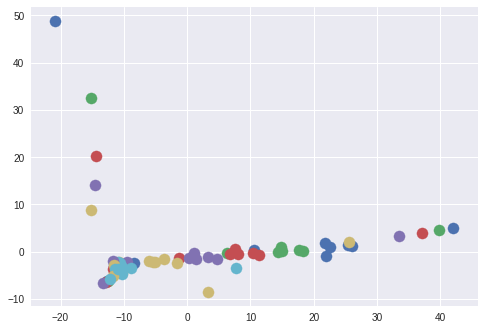

In [23]:
fig, ax = plt.subplots()
for i, met in enumerate(mets):
    #if met in ['thf', 'nac']:
    #ax.text(X_r[i, 0], X_r[i, 1], met)
    ax.scatter(X_r[i, 0], X_r[i, 1], s=125)
    

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook.py:136 MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.


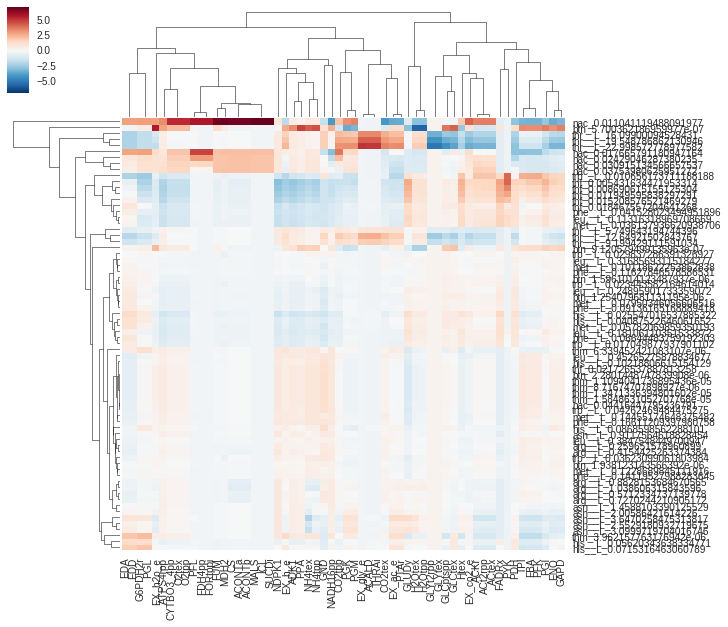

In [21]:
import seaborn as sns
filter_out = ['ser__L', 'atp', 'thr__L', 'ala__L', 'glu__L', 'gln__L']
new = pca_df.T[(abs(pca_df.sum()) > 0) & ~ pca_df.columns.isin(filter_out)]
new = new.T[abs(new).std(axis=0) > (abs(new).std(axis=0).mean() + 2* abs(new).std(axis=0).std())].T
g = sns.clustermap(new, z_score=1)
q = plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 

In [22]:
reruns = []
for met in norm_df.columns:
    a = norm_df[met][[i for i in norm_df.index if 'EX_' in i]]
    a = a[[i for i in a.index if i not in ['EX_ac_e', 'EX_co2_e', 'EX_h2o_e', 'EX_h_e', 'EX_adn_e', 'EX_pi_e', 'EX_akg_e', 'EX_nh4_e']]]
    if len( a[a>1]) > 0:
        print(a[a > 1])
        reruns.append(a.name)

PYK_FWD_PKI-COMPLEX_mod_mn2_mod_k    2.445865
Name: leu__L_0.11316318969708669, dtype: float64
PYK_FWD_PKI-COMPLEX_mod_mn2_mod_k    2.257786
Name: met__L_0.036137936620938706, dtype: float64
PYK_FWD_PKI-COMPLEX_mod_mn2_mod_k    6.160195
Name: thf_0.005431634471953314, dtype: float64
PYK_FWD_PKI-COMPLEX_mod_mn2_mod_k    5.198305
Name: thf_0.008690615155125304, dtype: float64
PYK_FWD_PKI-COMPLEX_mod_mn2_mod_k    4.312391
Name: thf_0.011949595838297291, dtype: float64
PYK_FWD_PKI-COMPLEX_mod_mn2_mod_k    3.282332
Name: thf_0.015208576521469279, dtype: float64
PYK_FWD_PKI-COMPLEX_mod_mn2_mod_k    1.310619
Name: thf_0.018467557204641268, dtype: float64
EX_gly_e    11.614092
Name: thr__L_12.64921502843767, dtype: float64
EX_gly_e    15.173924
Name: thr__L_16.09900094528431, dtype: float64
EX_gly_e    18.718031
Name: thr__L_19.548786862130946, dtype: float64
EX_gly_e    22.239577
Name: thr__L_22.998572778977582, dtype: float64
EX_gly_e    4.423972
Name: thr__L_5.749643194744396, dtype: float6

In [91]:
df.columns

Index(['leu__L_0.22632637939417338', 'leu__L_0.33948956909126005',
       'leu__L_0.45265275878834677', 'met__L_0.07227587324187741',
       'met__L_0.10841380986281612', 'met__L_0.14455174648375482',
       'nac_0.022082238976183954', 'nac_0.03312335846427593',
       'nac_0.04416447795236791', 'thf_0.010863268943906629',
       'thf_0.016294903415859943', 'thf_0.021726537887813258',
       'thm_1.1886473289530825e-05', 'thm_1.5848631052707768e-05',
       'thm_7.924315526353884e-06', 'trp__L_0.021312347422376376',
       'trp__L_0.03196852113356456', 'trp__L_0.04262469484475275'],
      dtype='object')

In [96]:
df = pd.read_csv('./titration/fluxes.csv', index_col=0)
with open('../iJL1678b_ML_keffs.pickle', 'rb') as f:
    me = pickle.load(f)
    
sol = cobra.core.Solution(.1, x_dict=df['thf_0.010863268943906629'].to_dict(),
                         status='optimal')

import escher
view = escher.Builder("iJO1366.Central metabolism")
view.reaction_data =  me.get_metabolic_flux(solution=sol)
view.display_in_notebook()


In [51]:
df['default']['biomass_dilution']

0.901753602424264

In [36]:
log2fc = (df['nac_0.02458499621830411'].clip_lower(1e-25).map(log2) - df['nac_0.04916999243660822'].clip_lower(1e-25).map(log2))
log2fc[abs(log2fc) > 5]

12DGR181tipp_FWD_CPLX_dummy                                                  -5.719175
2AGPA181tipp_FWD_EG12455-MONOMER                                             -6.334973
2AGPG180tipp_FWD_EG12455-MONOMER                                             -5.315417
3OAS1401_FWD_FABB-CPLX                                                      -78.950763
AACPS91_FWD_AAS-MONOMER_mod_mg2                                             -62.207620
ACALD_FWD_MHPF-MONOMER                                                      -69.592762
ACALDtex_REV_G6700-MONOMER                                                   69.111818
ACALDtpp_REV_SPONT                                                           69.111818
ACKr_REV_GARTRANSFORMYL2-MONOMER                                             83.904228
ADD_FWD_CPLX0-1683_mod_mn2                                                  -75.053308
ADPT_FWD_ADENPRIBOSYLTRAN-CPLX_mod_mn2                                       74.657061
ADSK_FWD_ADENYLYLSULFKIN-CPLX_mod_cobalt2  

In [118]:
me.metabolites.get_by_id('ACETYL-COA-CARBOXYLMULTI-CPLX_mod_btn').reactions

frozenset({<MetabolicReaction ACCOAC_FWD_ACETYL-COA-CARBOXYLMULTI-CPLX_mod_btn at 0x7f151e2a2908>,
           <ComplexFormation formation_ACETYL-COA-CARBOXYLMULTI-CPLX_mod_btn at 0x7f151e54b240>})

In [41]:
me.reactions.biomass_constituent_demand.reaction


'0.000223000000000000 10fthf_c + 0.000223000000000000 2ohph_c + 0.000576000000000000 coa_c + 0.141852194946855 glycogen_c + 0.000223000000000000 mlthf_c + 0.00183100000000000 nad_c + 0.000447000000000000 nadp_c + 0.000223000000000000 ribflv_c + 0.000223000000000000 thf_c + 5.50000000000000e-5 udcpdp_c --> 0.0255700194389810 constituent_biomass'

In [ ]:
aux_to_ko = {'thm': ['THZPSN31'],
             'nac': ['ASPO3', 'ASPO4', 'ASPO5', 'ASPO6'],
             'thf': ['DHFR'], # actually GCALLD, but seems unlikely
             'met__L': ['HSST'], # from flexneri 2a
             'trp__L': ['IGPS'],
             'leu__L' : ['IPMD'] # from DH10b
            } 

In [45]:
model = cobra.io.load_json_model('../all_m_models/iSSON_1240.json')

ijo = cobra.io.load_json_model('/home/sbrg-cjlloyd/Desktop/ecoli_M_models/iJO1366.json')

In [46]:
me.reactions.biomass_constituent_demand.reaction

'0.000223000000000000 10fthf_c + 0.000223000000000000 2ohph_c + 0.000576000000000000 coa_c + 0.141852194946855 glycogen_c + 0.000223000000000000 mlthf_c + 0.00183100000000000 nad_c + 0.000447000000000000 nadp_c + 0.000223000000000000 ribflv_c + 0.000223000000000000 thf_c + 5.50000000000000e-5 udcpdp_c --> 0.0255700194389810 constituent_biomass'

In [16]:
ijo.reactions.DHFR.knock_out()
ijo.add_reaction(model.reactions.SK_thf_c)
r = cobra.Reaction('SK_dhf_c')
ijo.add_reaction(r)
r.add_metabolites({'dhf_c': -1})
ijo.optimize()

<Solution 0.98 at 0x7ff9e5dbd668>

In [14]:
ijo.reactions.DHFR.reaction

'dhf_c + h_c + nadph_c --> nadp_c + thf_c'

In [266]:
other_e = cobra.io.load_json_model('../all_m_models/iSSON_1240.json')

In [6]:
for r in ijo.metabolites.thf_c.reactions:
    if 'BIOMASS' in r.id:
        continue
    print(r, r.reaction)

FTHFLi atp_c + for_c + thf_c --> 10fthf_c + adp_c + pi_c
FMETTRS 10fthf_c + mettrna_c --> fmettrna_c + h_c + thf_c
AICART 10fthf_c + aicar_c <=> fprica_c + thf_c
GLYCL gly_c + nad_c + thf_c --> co2_c + mlthf_c + nadh_c + nh4_c
METS 5mthf_c + hcys__L_c --> h_c + met__L_c + thf_c
GARFT 10fthf_c + gar_c <=> fgam_c + h_c + thf_c
FTHFD 10fthf_c + h2o_c --> for_c + h_c + thf_c
GHMT2r ser__L_c + thf_c <=> gly_c + h2o_c + mlthf_c
MOHMT 3mob_c + h2o_c + mlthf_c --> 2dhp_c + thf_c
ULA4NFT 10fthf_c + udpLa4n_c --> h_c + thf_c + udpLa4fn_c
DHFR dhf_c + h_c + nadph_c <=> nadp_c + thf_c


In [8]:
for i in ['a', 'b'] + ['b']:
    print(i)

a
b
b


In [268]:
for r in ijo.reactions:

    if r.id not in  model.reactions and "BIOMASS" not in r.id and not r.id.startswith('EX_'):
        test = ijo.copy()
        test.reactions.get_by_id(r.id).knock_out()
        sol = test.optimize()
        if not sol.f or sol.f <0.1:
            print(r, r.reaction, r.subsystem, r.gene_name_reaction_rule)
            print(sol.f)
            print(test.reactions.SK_thf_c.reaction)

IPMD 3c2hmp_c + nad_c --> 3c4mop_c + h_c + nadh_c Valine, Leucine, and Isoleucine Metabolism leuB
-1.204633234532363e-13


AttributeError: DictList has no attribute or entry SK_thf_c

In [248]:
for r in model.metabolites.query('aizc')[0].reactions:
    print(r, r.reaction)

PRASCSi_copy1 5aizc_c + asp__L_c + atp_c --> 25aics_c + adp_c + h_c + pi_c
PRASCSi_copy2 5aizc_c + asp__L_c + atp_c <=> 25aics_c + adp_c + h_c + pi_c
AIRC3 5aizc_c <=> 5caiz_c


In [134]:
me.reactions.get_by_id('ASPO3_FWD_L-ASPARTATE-OXID-MONOMER_mod_fad').reaction

'0.000100655456699342*mu L-ASPARTATE-OXID-MONOMER_mod_fad + asp__L_c + q8_c --> h_c + iasp_c + q8h2_c'

In [141]:
import cobrame
for r in me.metabolites.nicrnt_c.reactions:
    
    if isinstance(r, cobrame.MetabolicReaction):
        print(r.id, '\n',
              r.reaction)

NNATr_REV_NICONUCADENYLYLTRAN-MONOMER_mod_mg2 
 1.09151290659892e-5*mu NICONUCADENYLYLTRAN-MONOMER_mod_mg2 + dnad_c + ppi_c --> atp_c + h_c + nicrnt_c
NMNDA_FWD_CPLX_dummy 
 7.21875773992181e-5*mu CPLX_dummy + h2o_c + nmn_c --> nh4_c + nicrnt_c
NNATr_FWD_NICONUCADENYLYLTRAN-MONOMER_mod_mg2 
 6.61375661375661e-5*mu NICONUCADENYLYLTRAN-MONOMER_mod_mg2 + atp_c + h_c + nicrnt_c --> dnad_c + ppi_c
NAMNPP_FWD_NICOTINATEPRIBOSYLTRANS-MONOMER 
 0.000111077697468633*mu NICOTINATEPRIBOSYLTRANS-MONOMER + atp_c + h2o_c + nac_c + prpp_c --> adp_c + nicrnt_c + pi_c + ppi_c
NNDMBRT_FWD_DMBPPRIBOSYLTRANS-CPLX 
 6.14576431943193e-5*mu DMBPPRIBOSYLTRANS-CPLX + dmbzid_c + nicrnt_c --> 5prdmbz_c + h_c + nac_c
NNDPR_FWD_QUINOPRIBOTRANS-CPLX_mod_mg2 
 0.000603864734299517*mu QUINOPRIBOTRANS-CPLX_mod_mg2 + 2.0 h_c + prpp_c + quln_c --> co2_c + nicrnt_c + ppi_c


In [33]:
import escher
view = escher.Builder("iJO1366.Central metabolism")
view.reaction_data =  pca_df['nac'].dropna().to_dict()
view.display_in_notebook()